In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from pandas import read_csv
py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
dataset = pd.read_csv('bitcoin.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1556 non-null   object 
 1   Open        1556 non-null   float64
 2   High        1556 non-null   float64
 3   Low         1556 non-null   float64
 4   Close       1556 non-null   float64
 5   Volume      1556 non-null   object 
 6   Market Cap  1556 non-null   object 
dtypes: float64(4), object(3)
memory usage: 85.2+ KB


In [4]:
dataset.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


In [5]:
dataset.tail()

,Date,Open,High,Low,Close,Volume,Market Cap
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"
1555,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,"1,500,520,000"


In [6]:
btc_trace = go.Scatter(x=dataset.index, y=dataset['Close'], name= 'Close')
py.iplot([btc_trace])

In [7]:
dataset['Close'].replace(0, np.nan, inplace=True)
dataset['Close'].fillna(method='ffill', inplace=True)

In [8]:
btc_trace = go.Scatter(x=dataset.index, y=dataset['Close'], name= 'Cap')
py.iplot([btc_trace])

In [9]:
from sklearn.preprocessing import MinMaxScaler
values = dataset['Close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [10]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1089 467


In [11]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [12]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1088
466


In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

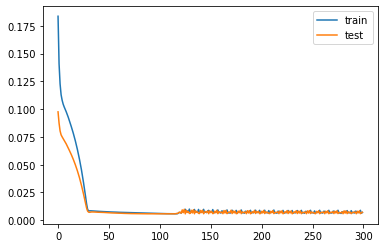

In [15]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

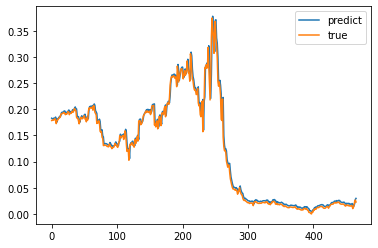

In [16]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [17]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

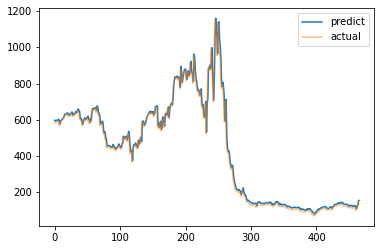

In [18]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [19]:
predictDates = dataset.tail(len(testX)).index

In [20]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [23]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f'Mean Absolute Error = {mean_absolute_error(yhat, testY)}')
print(f'Mean Squared Error = {mean_squared_error(yhat, testY)}')
print(f'r^2 score = {r2_score(yhat, testY)}')

Mean Absolute Error = 0.007172184996306896
Mean Squared Error = 0.00015339073434006423
r^2 score = 0.9836004256071403
